In [1]:
%matplotlib inline


# Fitting an image and points

In this example, we will fit a cross onto the same cross, but rotated. We will take advantage of this knowledge and use a rotation deformation module. We will also add some noise on the initial center guess to show how to fit the geometrical descriptors. In addition to images, we add points at the extremity of each branch that will also get matched in order to illustrate multi deformables matching. This also helps the fitting process by adding more information to the model.




Import relevant modules.




In [2]:
import sys
sys.path.append("../")

import math

import torch
import matplotlib.pyplot as plt
import scipy.ndimage

import imodal

imodal.Utilities.set_compute_backend('torch')

Load image data and generate dots.




In [3]:
source_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+_30.png", origin='lower')
target_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+.png", origin='lower')

# Smoothing
sig_smooth = 0.
source_image = torch.tensor(scipy.ndimage.gaussian_filter(source_image, sig_smooth))
target_image = torch.tensor(scipy.ndimage.gaussian_filter(target_image, sig_smooth))

extent_length = 31.
extent = imodal.Utilities.AABB(0., extent_length, 0., extent_length)

center = extent_length*torch.tensor([[0.3, 0.1]])
print(center)
#center = extent_length*torch.tensor([[0.5, 0.5]])

tensor([[9.3000, 3.1000]])


Plot everything.




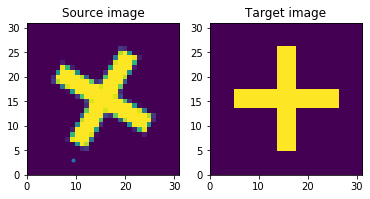

In [4]:
plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image, origin='lower', extent=extent.totuple())
plt.plot(center.numpy()[:, 0], center.numpy()[:, 1], '.')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image, origin='lower', extent=extent.totuple())

plt.show()

We know that the target cross is the result of some rotation at its origin,
so we use a local rotation deformation module, with an imprecise center
position to simulate data aquisition noise.




In [5]:
rotation = imodal.DeformationModules.LocalRotation(2, 2.*extent_length, gd=center)

Create the model by setting `True` for `fit_gd` so that it also optimize the
rotation center.




In [6]:
source_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=False)
target_deformable = imodal.Models.DeformableImage(target_image, output='bitmap', extent='match', backward=False)

attachment = imodal.Attachment.L2NormAttachment(transform=None)

model = imodal.Models.RegistrationModel([source_deformable], [rotation], [attachment], fit_gd=[True], lam=200.)

Fit the model.




In [7]:
shoot_solver = 'rk4'
shoot_it = 10
max_it = 100

costs = {}
fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS, using solver rk4 with 10 iterations.
Initial cost={'deformation': 0.0, 'attach': 39664.69921875}
1e-10
Evaluated model with costs=39664.69921875
Evaluated model with costs=39334.67449479271
Evaluated model with costs=39178.0787467435
Evaluated model with costs=37364.847511053085
Evaluated model with costs=32399.906215667725
Evaluated model with costs=50492.83642578125
Evaluated model with costs=27298.386795043945
Evaluated model with costs=27170.28480529785
Evaluated model with costs=27115.617904663086
Evaluated model with costs=26629.894775390625
Evaluated model with costs=25077.144821166992
Evaluated model with costs=28586.999588012695
Evaluated model with costs=24583.671798706055
Evaluated model with costs=23327.672149658203
Evaluated model with costs=20510.842864990234
Evaluated model with costs=34919.15869140625
Evaluated model with costs=13910.57778930664
Evaluated model with costs=12276.884307861328
Evaluated model with costs=11865.

Compute the final deformed source and plot it.




Fitted rotatation center: [[15.522558212280273, 15.475604057312012]]


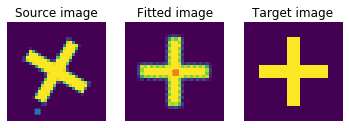

In [8]:
intermediates = {}
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

    deformed_image = deformed[0][0].view_as(source_image)

fitted_center = model.init_manifold[1].gd.detach()
fitted_center_final = intermediates['states'][-1][1].gd.detach()

print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.plot(fitted_center_final.numpy()[0, 0], fitted_center_final.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image.numpy(), origin='lower', extent=extent.totuple())
plt.axis('off')

plt.show()